# Script for DocX

## Notebook Purpose
DOCX Generation
 
## Tasks
- Data Discover
- Format
- Wrangling
- Analysis
- Jinja2
- Docxtpl

## Notable TODOs:
--

---

# Setup

### Path

In [1]:
import sys
from pathlib import Path

NB_FOLDER = 'notebooks'
NB_PATH = Path.cwd()
B_PATH = NB_PATH.parent

main_spaths = ['scripts', 'data', 'client_credit_union']
main_paths = [(B_PATH / m_spath) for m_spath in main_spaths]
data_spaths = ['external', 'interim', 'processed', 'raw']
data_paths = [(B_PATH / 'data' / data_spath) for data_spath in data_spaths]
data_processed_spaths = ['results', 'training']
data_processed_paths = [(B_PATH / 'data' / 'processed' / datap_spath) for datap_spath in data_processed_spaths]
project_paths = main_paths + data_paths + data_processed_paths

if NB_PATH.stem == NB_FOLDER:
	# Create Project Folders and Set Paths
	for p_path in project_paths:
		p_path.mkdir(exist_ok=True, parents=True)
		p_name = p_path.name
		v_name = f"DATA_{p_name}_PATH" if p_path.parent.name == 'data' else f"{p_name}_PATH"
		globals()[v_name.upper()] = p_path

	# Custom Paths

	# Append SCRIPTS as Python Path
	sys.path.append(client_credit_union_PATH.as_posix())
	sys.path.append(SCRIPTS_PATH.as_posix())

### Installation

In [ ]:
!uv add \
	--extra-index-url=https://pypi.nvidia.com \
	cudf-cu12==25.2.2
!uv add python-dotenv
!uv add docxtpl
!uv add mammoth docx2md markitdown
!uv add docx2pdf
!uv add msoffice2pdf
!uv add google-api-python-client google-auth-httplib2 google-auth-oauthlib
!uv add Spire.Doc.Free
!uv add openpyxl

Resolved 261 packages in 7ms
Audited 255 packages in 0.07ms
Resolved 261 packages in 0.37ms
Audited 255 packages in 0.06ms
Resolved 261 packages in 0.43ms
Audited 255 packages in 0.06ms
Resolved 261 packages in 0.38ms
Audited 255 packages in 0.06ms
Resolved 261 packages in 0.42ms
Audited 255 packages in 0.06ms
Resolved 261 packages in 0.38ms
Audited 255 packages in 0.06ms
Resolved 261 packages in 0.36ms
Audited 255 packages in 0.06ms
Resolved 261 packages in 0.36ms
Audited 255 packages in 0.06ms
Resolved 263 packages in 7.68s                                       
   Building client-credit-union @ file:///home/leobit/Development/interna
   Building client-credit-union @ file:///home/leobit/Development/interna
      Built client-credit-union @ file:///home/leobit/Development/interna
Prepared 1 package in 253ms                                              
Uninstalled 1 package in 0.91ms
Installed 3 packages in 11ms                                
 + et-xmlfile==2.0.0
 ~ client-credit-un

### System Infomation

In [45]:
!bash {SCRIPTS_PATH.as_posix()}/notebook_info.sh

## GLOBAL INFO
Conda Python Version: 3.12.9.final.0
Conda Base Path: /opt/miniconda3
Conda Base Version: 25.1.1

## ENVIRONMENT INFO
Active Environment: None
Environment Python Version: Python 3.11.11
Environment Python Path: /home/leobit/Development/client-credit-union/.venv/bin/python
Environment IPython Version: 9.2.0
Environment IPykernel Version: 6.29.5

## GPU INFO:
CUDA Device Initialized <frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cuda module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.driver module instead.
True

GPU Info: Mon Jun  2 15:31:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.04              Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile U

### Import

In [2]:
## Extensions
if 'autoreload' not in get_ipython().extension_manager.loaded:
	%load_ext autoreload
%autoreload 2
%load_ext cudf.pandas
%load_ext dotenv

In [3]:
import pandas as pd
import warnings
from dotenv import load_dotenv
# import torch
from save_utils import save_obj, load_obj, run_api
from IPython import get_ipython
from IPython.core.magic import register_cell_magic

### Configuration

In [4]:
# Pandas
pd.set_option('max_colwidth', 300)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 300)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


# Future Warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# Env+
%dotenv {(B_PATH / '.env').as_posix()}
load_dotenv(override=True)

# Torch Version
# print(f"Torch Version: {torch. __version__}")

# Torch Cuda Available
# torch.cuda.is_available()

True

In [5]:
ipython = get_ipython()
@register_cell_magic
def pybash(line, cell):
	ipython.run_cell_magic('bash', '', cell.format(**globals()))

# Reproduce Visualization

In [6]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.table import Table
import matplotlib.patches as mpatches

from datetime import datetime
from collections import Counter

## Preprocess

In [7]:
def first_last(name):
  parts = name.strip().lower().split()
  return f"{parts[0]} {parts[-1]}" if len(parts) > 1 else parts[0]

def loan_df_from_records(loan_json_path):
	df = pd.read_json(loan_json_path)
	
	records = []
	for loan in df.to_dict(orient='records'):
		flat_record = {"loanId": loan["loanId"], "folder": loan["folder"]}
		flat_record.update(loan["fields"])
		records.append(flat_record)

	df = pd.DataFrame(records)
	return df

def preprocess(loan_json_path, credit_excel_path):
	
	# Open Credit Excel File
	xls = pd.ExcelFile(credit_excel_path)
	credit_df = xls.parse('Sheet0') # credit_df = xls.parse('Export Worksheet')
	credit_df.columns = [col.strip() for col in credit_df.columns]
	credit_df = credit_df.rename(columns={'OPERATOR_NAME': 'Loan Officer'})
	credit_df['Loan Officer'] = credit_df['Loan Officer'].str.strip().str.lower()

	# Melt Excel to long format
	credit_long = credit_df.melt(id_vars='Loan Officer',
								var_name='Scenario',
								value_name='Credit Pulls').dropna()
	credit_totals = credit_long.groupby('Loan Officer')['Credit Pulls'].sum().reset_index()
	

	# Load the JSON file with loan data
	with open(loan_json_path, 'r') as f:
		loan_data = json.load(f)

	# Filter only closed loans
	closed_loans = [loan for loan in loan_data if loan.get('folder') == 'Closed 2025']

	# === Normalize and Count Closed Loans per Officer ===
	closed_officers = [first_last(loan['fields']['317']) for loan in closed_loans if loan['fields'].get('317')]
	closed_per_officer = pd.Series(closed_officers).value_counts().reset_index()
	closed_per_officer.columns = ['Loan Officer', 'Closed Loans']

	# === Merge Loan Officer Data ===
	credit_totals['Normalized Name'] = credit_totals['Loan Officer'].apply(first_last)
	closed_per_officer['Normalized Name'] = closed_per_officer['Loan Officer'].apply(first_last)

	credit_totals_grouped = credit_totals.groupby('Normalized Name')['Credit Pulls'].sum().reset_index()
	closed_grouped = closed_per_officer.groupby('Normalized Name')['Closed Loans'].sum().reset_index()

	merged = pd.merge(credit_totals_grouped, closed_grouped, on='Normalized Name', how='outer').fillna(0)
	merged['Credit Pulls'] = merged['Credit Pulls'].astype(int)
	merged['Closed Loans'] = merged['Closed Loans'].astype(int)
	merged['Close Rate (%)'] = merged.apply(lambda r: round((r['Closed Loans']/r['Credit Pulls'])*100, 1) if r['Credit Pulls'] > 0 else None, axis=1)
	merged['Loans per Pull'] = merged.apply(lambda r: round((r['Closed Loans']/r['Credit Pulls']), 2) if r['Credit Pulls'] > 0 else None, axis=1)
	merged['Loan Officer'] = merged['Normalized Name'].apply(lambda x: ' '.join([w.capitalize() for w in x.split()]))

	# === Map ORGID (Branch) for Each Loan Officer ===
	officer_branch_amount_triplets = [
	(
		first_last(loan['fields'].get('317')),
		loan['fields'].get('ORGID'),
		float(str(loan['fields'].get('2')).replace('$', '').replace(',', '').strip())
	)
	for loan in closed_loans
	if loan['fields'].get('317') and loan['fields'].get('ORGID') and loan['fields'].get('2')
	]

	officer_branch_amount_df = pd.DataFrame(officer_branch_amount_triplets, columns=['Normalized Name', 'ORGID', 'Loan Amount'])

	officer_branch_map = officer_branch_amount_df.groupby('Normalized Name')['ORGID'] \
		.agg(lambda x: Counter(x).most_common(1)[0][0]).reset_index()
	officer_amount_map = officer_branch_amount_df.groupby('Normalized Name')['Loan Amount'].sum().reset_index()

	merged = pd.merge(merged, officer_branch_map, on='Normalized Name', how='left')
	merged = pd.merge(merged, officer_amount_map, on='Normalized Name', how='left')
	merged['Loan Amount'] = merged['Loan Amount'].fillna(0).astype(float)

	return merged

In [8]:
def generate_loan_officer_by_efficiency_table(df):
	top30_table = df[df['Credit Pulls'] > 0].copy()
	top30_table = top30_table.sort_values(by='Loans per Pull', ascending=False).head(30)

	# Replace NaN in 'ORGID' with '-'
	top30_table['ORGID'] = top30_table['ORGID'].fillna('-')

	# Rename ORGID to Branch for display
	top30_table = top30_table.rename(columns={'ORGID': 'Branch'})

	# Reorder columns with Branch first
	top30_table = top30_table.rename(columns={'ORGID': 'Branch'})
	top30_table = top30_table[['Branch', 'Loan Officer', 'Closed Loans', 'Credit Pulls', 'Loan Amount', 'Loans per Pull']]
	top30_table['Loan Amount'] = top30_table['Loan Amount'].apply(lambda x: f"${x:,.0f}")
	return top30_table

def generate_closed_pulls_table(df):
	top30 = df.sort_values(by='Closed Loans', ascending=False).head(30)
	return top30

def generate_closed_pulls_by_branch_table(df):
	branch_summary = df.groupby('ORGID').agg({
		'Closed Loans': 'sum',
		'Credit Pulls': 'sum'
	}).reset_index()
	branch_summary['Loans per Pull'] = (branch_summary['Closed Loans'] / branch_summary['Credit Pulls']).round(2)

	sorted_branch = branch_summary.sort_values(by='Closed Loans', ascending=False)
	return sorted_branch

In [9]:
loan_json_path = DATA_RAW_PATH / 'loan_field_data.json'
credit_excel_path = DATA_RAW_PATH / 'CreditUnionHomeMortgageMultimodalReport3454627734656384028.xlsx'

merged = preprocess(loan_json_path, credit_excel_path)
loan_df = loan_df_from_records(loan_json_path)
loan_officer_by_efficiency_table = generate_loan_officer_by_efficiency_table(merged)
closed_pulls_table = generate_closed_pulls_table(merged)
closed_pulls_by_branch_table = generate_closed_pulls_by_branch_table(merged)

time_label = "May 2025"
month_label = "May"
year_label = "2025"
time_label = f"{month_label} {year_label}"
prefix = "report_3"
show_appendix = True

image_path = DATA_INTERIM_PATH / "report_images"

## Visualization

In [10]:
def generate_shades(base_hex, n_shades):
	base_rgb = mcolors.to_rgb(base_hex)
	shades = []
	for i in range(n_shades):
		factor = 0.6 + 0.4 * (i / max(1, n_shades - 1))
		shade = tuple(min(1, c * factor) for c in base_rgb)
		shades.append(mcolors.to_hex(shade))
	return shades[::-1]

def first_last(name):
	parts = name.strip().lower().split()
	return f"{parts[0]} {parts[-1]}" if len(parts) > 1 else parts[0]

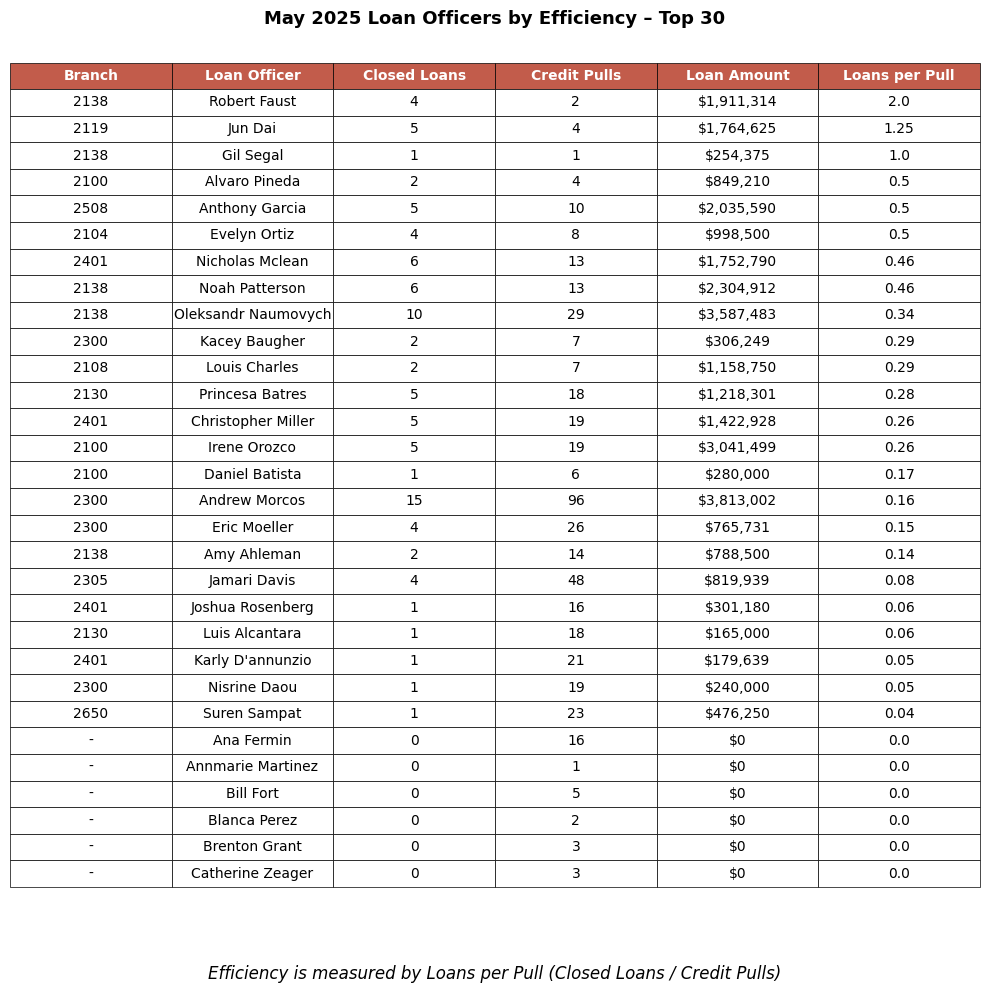

In [11]:
def plot_loan_officer_by_efficiency(table, image_path, prefix, time_label, show_plots=False, graph_name = "loan_officer_by_efficiency"):
	top30_table = table
	# Plot styled table
	fig, ax = plt.subplots(figsize=(10, 10))
	ax.set_axis_off()
	tbl = Table(ax, bbox=[0, 0.1, 1, 0.85])
	data = [top30_table.columns.tolist()] + top30_table.values.tolist()

	tbl.auto_set_font_size(False)
	tbl.set_fontsize(12)

	n_rows, n_cols = len(data), len(data[0])
	width, height = 1.0 / n_cols, 0.85 / n_rows

	for i, row in enumerate(data):
		for j, val in enumerate(row):
			cell = tbl.add_cell(i, j, width, height, text=str(val), loc='center',
								facecolor='#c25c4b' if i == 0 else 'white')
			cell.set_edgecolor('black')
			cell.set_linewidth(0.5)
			if i == 0:
				cell.get_text().set_color('white')
				cell.get_text().set_weight('bold')

	ax.add_table(tbl)

	fig.text(0.5, 0.975, f"{time_label} Loan Officers by Efficiency – Top 30", ha='center', fontsize=13, weight='bold')
	fig.text(0.5, 0.02, "Efficiency is measured by Loans per Pull (Closed Loans / Credit Pulls)", ha='center', fontsize=12, style='italic')

	plt.tight_layout()
	if show_plots:
		plt.show()
	if image_path and prefix:
		fig.savefig(image_path / f"{prefix}_{graph_name}.png")
	plt.close(fig)
	
plot_loan_officer_by_efficiency(
	table=loan_officer_by_efficiency_table,
	graph_name="loan_officer_by_efficiency_top30",
	image_path=image_path,
	prefix=prefix,
	time_label=time_label,
	show_plots=True
)

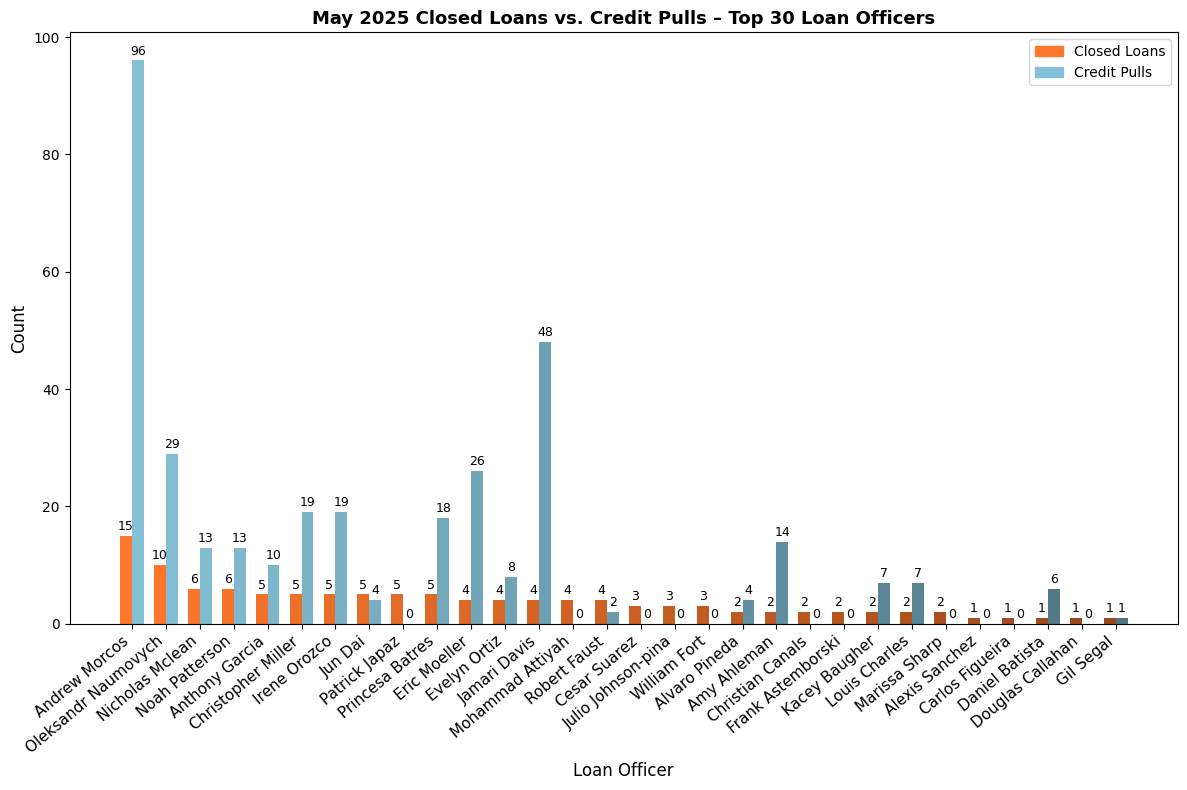

In [12]:
def plot_closed_pulls(table, image_path, prefix, time_label, show_plots=False, graph_name = "closed_pulls_top30"):
	# === 3. Graph – Closed Loans vs. Credit Pulls (Top 30) with custom shades ===
	top_30 = table
	x = range(len(top_30))
	bar_width = 0.35

	closed_shades = generate_shades("#ff782c", len(top_30))
	pulls_shades = generate_shades("#84c0d6", len(top_30))

	fig, ax = plt.subplots(figsize=(12, 8))
	for i in x:
		ax.bar(i, top_30['Closed Loans'].iloc[i], width=bar_width, color=closed_shades[i])
		ax.bar(i + bar_width, top_30['Credit Pulls'].iloc[i], width=bar_width, color=pulls_shades[i])
		ax.text(i, top_30['Closed Loans'].iloc[i] + 1,
					f"{top_30['Closed Loans'].iloc[i]}", ha='center', fontsize=9)

		ax.text(i + bar_width, top_30['Credit Pulls'].iloc[i] + 1,
					f"{top_30['Credit Pulls'].iloc[i]}", ha='center', fontsize=9)

	ax.set_xticks([i + bar_width / 2 for i in x])
	ax.set_xticklabels(top_30['Loan Officer'], rotation=40, ha='right', fontsize=11)
	ax.set_xlabel("Loan Officer", fontsize=12)
	ax.set_ylabel("Count", fontsize=12)
	ax.set_title(f"{time_label} Closed Loans vs. Credit Pulls – Top 30 Loan Officers", fontsize=13, weight='bold')

	closed_patch = mpatches.Patch(color="#ff782c", label='Closed Loans')
	pulls_patch = mpatches.Patch(color="#84c0d6", label='Credit Pulls')
	ax.legend(handles=[closed_patch, pulls_patch], loc='upper right')

	plt.tight_layout()
	if show_plots:
		plt.show()
	if image_path and prefix:
		fig.savefig(image_path / f"{prefix}_{graph_name}.png")
	plt.close(fig)
	
plot_closed_pulls(
	table=closed_pulls_table,
	graph_name="closed_pulls_top30",
	image_path=image_path,
	prefix=prefix,
	time_label=time_label,
	show_plots=True

)

In [13]:
def plot_closed_pulls_by_branch(table, image_path, prefix, time_label, show_plots=False, graph_name = "closed_pulls_by_branch"):
	sorted_branch = table
	fig, ax = plt.subplots(figsize=(12, 6))
	x = range(len(sorted_branch))
	bar_width = 0.4

	closed_shades = generate_shades("#e6970c", len(sorted_branch))
	pulls_shades = generate_shades("#d2042d", len(sorted_branch))

	# Plot bars for Closed Loans and Credit Pulls
	for i in x:
		ax.bar(i, sorted_branch['Closed Loans'].iloc[i], width=bar_width, color=closed_shades[i])
		ax.bar(i + bar_width, sorted_branch['Credit Pulls'].iloc[i], width=bar_width, color=pulls_shades[i])

		# Add value labels
		ax.text(i, sorted_branch['Closed Loans'].iloc[i] + 1,
				f"{sorted_branch['Closed Loans'].iloc[i]}", ha='center', fontsize=9)
		ax.text(i + bar_width, sorted_branch['Credit Pulls'].iloc[i] + 1,
				f"{sorted_branch['Credit Pulls'].iloc[i]}", ha='center', fontsize=9)

	# X-axis labels and styling
	ax.set_xticks([i + bar_width / 2 for i in x])
	ax.set_xticklabels(sorted_branch['ORGID'], rotation=30, ha='right', fontsize=10)
	ax.set_xlabel("Branch", fontsize=12)
	ax.set_ylabel("Volume", fontsize=12)
	ax.set_title(f"{time_label} Closed Loans vs. Credit Pulls by Branch", fontsize=14, weight='bold')

	closed_patch = mpatches.Patch(color="#e6970c", label='Closed Loans')
	pulls_patch = mpatches.Patch(color="#d2042d", label='Credit Pulls')
	ax.legend(handles=[closed_patch, pulls_patch], loc='upper right')

	plt.tight_layout()
	if show_plots:
		plt.show()
	if image_path and prefix:
		fig.savefig(image_path / f"{prefix}_{graph_name}.png")
	plt.close(fig)
	
plot_closed_pulls_by_branch(
	table=closed_pulls_by_branch_table,
	graph_name="closed_pulls_by_branch",
	image_path=image_path,
	prefix=prefix,
	time_label=time_label,
	show_plots=False
)

## Context

In [14]:
from docxtpl import DocxTemplate, InlineImage
from docx import Document
from docx.oxml.ns import qn
from docx.shared import Inches
import shutil

In [15]:
tpl = DocxTemplate(DATA_INTERIM_PATH / 'templates' / 'report_3.docx')
set_of_variables = tpl.get_undeclared_template_variables()
appendix_sd = tpl.new_subdoc(DATA_INTERIM_PATH / 'templates' / 'report_3_appendix.docx')


In [16]:
set_of_variables

{'appendix_sd',
 'cl_cleared_qtd',
 'cl_cred_pulls_qtd',
 'cl_fund_m',
 'cl_fund_yr',
 'cl_pulltoc_name_max',
 'cl_pulltoc_name_min',
 'cl_pulltoc_ratio_max',
 'cl_pulltoc_ratio_min',
 'cl_qtd',
 'cl_report_d',
 'cl_report_m',
 'cl_report_num',
 'cl_report_v',
 'cl_report_yr',
 'cl_sent_branch_qtd',
 'cl_yr',
 'report_3_closed_pulls_by_branch_img',
 'report_3_closed_pulls_top30_img',
 'report_3_loan_officer_by_efficiency_top30_img',
 'show_appendix'}

In [1]:
def add_images_context(tpl, context, images_path):
	half_width_imgs = ["final_chart_closed_banked_-_retail_img", "final_chart_closed_banked_-_wholesale_img"]
	for path in images_path.glob("*.png"):
		context_img = f"{path.stem}_img"
		if context_img in half_width_imgs:
			width = Inches(3.25)
		else:
			width = Inches(6.5)
		context[context_img] = InlineImage(tpl=tpl, image_descriptor=path.as_posix(), width=width)
	return context

def get_template_context(merged, loan_df, tpl, images_path, appendix_sd=None, show_appendix=True, month_label=None, year_label=None):
	# Quantity of Loans
	cl_qtd = len(loan_df)
	
	# Quantity of Closed Loans and Credit Pulls
	cl_cleared_qtd = merged["Closed Loans"].sum()
	cl_cred_pulls_qtd = merged["Credit Pulls"].sum()
	
	# Min and Max Close Rate
	min_idx = merged[merged["Close Rate (%)"]>0]["Close Rate (%)"].idxmin()
	max_idx = merged[merged["Close Rate (%)"]>0]["Close Rate (%)"].idxmax()
	min_name, min_rate = merged.iloc[min_idx]["Loan Officer"], merged.iloc[min_idx]["Close Rate (%)"]
	max_name, max_rate = merged.iloc[max_idx]["Loan Officer"], merged.iloc[max_idx]["Close Rate (%)"]
	cl_pulltoc_name_max = max_name
	cl_pulltoc_name_min = min_name
	cl_pulltoc_ratio_max = max_rate
	cl_pulltoc_ratio_min = min_rate

	# Report Date
	cl_report_m = datetime.now().strftime("%B")
	cl_report_d = datetime.now().strftime("%-d")
	cl_report_yr = datetime.now().strftime("%Y")
	
	# TODO:
	cl_sent_branch_qtd = 8

	context = {
		'appendix_sd': appendix_sd,
		'cl_cleared_qtd': cl_cleared_qtd,
		'cl_cred_pulls_qtd': cl_cred_pulls_qtd,
		'cl_fund_m' : month_label,
		'cl_fund_yr' : year_label,
		'cl_pulltoc_name_max': cl_pulltoc_name_max,
		'cl_pulltoc_name_min': cl_pulltoc_name_min,
		'cl_pulltoc_ratio_max': cl_pulltoc_ratio_max,
		'cl_pulltoc_ratio_min': cl_pulltoc_ratio_min,
		'cl_qtd' : cl_qtd,
		'cl_report_num': '3',
		'cl_report_v': '0.1',
		'cl_report_m' : cl_report_m,
		'cl_report_d' : cl_report_d,
		'cl_report_yr' : cl_report_yr,
		'cl_sent_branch_qtd': cl_sent_branch_qtd,
		'cl_yr': year_label,
		"show_appendix": str(show_appendix)
	}
	context = add_images_context(tpl, context, images_path)

	return context

In [2]:
context = get_template_context(merged, loan_df, tpl, image_path, appendix_sd, show_appendix, month_label, year_label)

NameError: name 'merged' is not defined

In [19]:
context

{'appendix_sd': <docxtpl.subdoc.Subdoc at 0x7f92c3015dd0>,
 'cl_cleared_qtd': np.int64(123),
 'cl_cred_pulls_qtd': np.int64(606),
 'cl_fund_m': 'May',
 'cl_fund_yr': '2025',
 'cl_pulltoc_name_max': 'Robert Faust',
 'cl_pulltoc_name_min': 'Suren Sampat',
 'cl_pulltoc_ratio_max': np.float64(200.0),
 'cl_pulltoc_ratio_min': np.float64(4.3),
 'cl_qtd': 358,
 'cl_report_num': '3',
 'cl_report_v': '0.1',
 'cl_report_m': 'June',
 'cl_report_d': '5',
 'cl_report_yr': '2025',
 'cl_sent_branch_qtd': 8,
 'cl_yr': '2025',
 'show_appendix': 'True',
 'report_3_closed_pulls_top30_img': <docxtpl.inline_image.InlineImage at 0x7f92c0afbed0>,
 'report_3_loan_officer_by_efficiency_top30_img': <docxtpl.inline_image.InlineImage at 0x7f92c0aed0d0>,
 'report_3_closed_pulls_by_branch_img': <docxtpl.inline_image.InlineImage at 0x7f92c0aeed90>}

## Final Script

In [20]:
loan_json_path = DATA_RAW_PATH / 'loan_field_data.json'
credit_excel_path = DATA_RAW_PATH / 'CreditUnionHomeMortgageMultimodalReport3454627734656384028.xlsx'

time_label = "May 2025"
month_label = "May"
year_label = "2025"
time_label = f"{month_label} {year_label}"
prefix = "report_3"
show_appendix = True

image_path = DATA_INTERIM_PATH / "report_images"

In [21]:
def get_graph_tables(merged):
	loan_officer_by_efficiency_table = generate_loan_officer_by_efficiency_table(merged)
	closed_pulls_table = generate_closed_pulls_table(merged)
	closed_pulls_by_branch_table = generate_closed_pulls_by_branch_table(merged)
	tables = [loan_officer_by_efficiency_table, closed_pulls_table, closed_pulls_by_branch_table]
	return tables

def gen_images_report_3(tables, images_path, prefix, time_label):
	loan_officer_by_efficiency_table, closed_pulls_table, closed_pulls_by_branch_table = tables
	plot_loan_officer_by_efficiency(
		table=loan_officer_by_efficiency_table,
		graph_name="loan_officer_by_efficiency_top30",
		image_path=image_path,
		prefix=prefix,
		time_label=time_label,
		show_plots=False
	)

	plot_closed_pulls(
		table=closed_pulls_table,
		graph_name="closed_pulls_top30",
		image_path=image_path,
		prefix=prefix,
		time_label=time_label,
		show_plots=False
	)
	plot_closed_pulls_by_branch(
		table=closed_pulls_by_branch_table,
		graph_name="closed_pulls_by_branch",
		image_path=image_path,
		prefix=prefix,
		time_label=time_label,
		show_plots=False
	)

def remove_images(images_path):
	for path in sorted((images_path).glob("*")):
		path.unlink()

def gen_docx_report(merged, loan_df, doc_template_path, appendix_template_path, images_path, output_path, month_label, year_label):
	tpl = DocxTemplate(doc_template_path)
	appendix_sd = tpl.new_subdoc(appendix_template_path)
	show_appendix = True
	context = get_template_context(merged, loan_df, tpl, images_path, appendix_sd, show_appendix, month_label, year_label)
	tpl.render(context, autoescape=True)
	tpl.save(output_path)
	# remove_images(images_path)
	
	return output_path


def run(month_label, year_label, loan_json_path, credit_excel_path, images_path, doc_template_path, appendix_template_path, output_path):
	merged = preprocess(loan_json_path, credit_excel_path)
	loan_df = loan_df_from_records(loan_json_path)
	tables = get_graph_tables(merged)
	time_label = f"{month_label} {year_label}"
	prefix = "report_3"
	gen_images_report_3(tables, images_path, prefix, time_label)
	output_path = gen_docx_report(
		merged=merged,
		loan_df=loan_df,
		doc_template_path=doc_template_path,
		appendix_template_path=appendix_template_path,
		images_path=images_path,
		output_path=output_path,
		month_label=month_label,
		year_label=year_label
	)
	return output_path

In [28]:
loan_json_path = DATA_RAW_PATH / 'loan_field_data.json'
credit_excel_path = DATA_RAW_PATH / 'CreditUnionHomeMortgageMultimodalReport3454627734656384028.xlsx'

time_label = "May 2025"
month_label = "May"
year_label = "2025"
time_label = f"{month_label} {year_label}"
prefix = "report_3"
show_appendix = True

images_path = DATA_INTERIM_PATH / 'report_images'
templates_path = DATA_INTERIM_PATH / 'templates'
output_folder = DATA_INTERIM_PATH / 'output'
doc_template_path = templates_path / f'{prefix}.docx'
appendix_template_path = templates_path / f'{prefix}_appendix.docx'
output_path = output_folder / f'{prefix}_{month_label}_{year_label}.docx'

run(month_label, year_label, loan_json_path, credit_excel_path, images_path, doc_template_path, appendix_template_path, output_path)

PosixPath('/home/leobit/Development/client-credit-union/data/interim/output/report_3_May_2025.docx')